In [1]:
#Imports
import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from tensorflow.examples.tutorials.mnist import input_data
import keras
import numpy as np
from keras.models import Model
import inspect
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
from keras.models import load_model
import numpy as np
from keras import optimizers


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Constants
PRE_TRAIN_ITER= 100
TRAIN_ITER=100
BATCH_SIZE = 256
LEARNING_RATE = 0.001
num_of_test_images=10
save_path = "C:\\Users\\arsee\\Desktop\dir2\\"
learn = False
learning_rate =0.01
momentum =1
tol = 0.001

In [3]:
#laod Data
dataset = input_data.read_data_sets('/tmp/MNIST_data')
train_x = dataset.train.images
train_y =dataset.train.labels
test_x =dataset.test.images
trainx =train_x[:10000]
trainy =train_y[:10000]

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data\train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def pre_train(encoder,decoder,data):
    inp  = Input(shape=(len(data[0]),))
    l1 = Dropout(0.2)(inp)
    l2 = encoder(l1)
    l3 = Dropout(0.2)(l2)
    l4 = decoder(l3)    
    autoencoder = Model(inp, l4)
    autoencoder.compile(optimizer='adadelta', loss='mse')
    autoencoder.fit(data, data,
                epochs=PRE_TRAIN_ITER,
                batch_size=BATCH_SIZE,
                shuffle=True)
    
    return autoencoder
    

In [5]:
input_img = Input(shape=(784,))
if learn:
    l1  = Dense(500, activation='relu')
    l2  = Dense(500, activation='relu')
    l3  = Dense(2000, activation='relu')
    l4  = Dense(10, activation='sigmoid')

    d4 =Dense(2000, activation='relu')
    d3 =Dense(500, activation='relu')
    d2 =Dense(500, activation='relu')
    d1 =Dense(784, activation='sigmoid')

    encoders = [l1,l2,l3,l4]
    decoders = [d1,d2,d3,d4]


    stacked_encoders =[input_img]
    stacked_decoders = []
    data = train_x


    for i in range(0,4):
        model= pre_train(encoders[i],decoders[i],data)
        layers = [l for l in model.layers]
        enc =layers[2]
        #print(inspect.getmembers(enc, predicate=inspect.ismethod))
        dec = layers[4]
        enc = enc(stacked_encoders[i])
        stacked_encoders.append(enc)
        stacked_decoders.append(dec)

        #data = enc.predict(train_x)
        gem =Model(input_img,enc)
        data = gem.predict(train_x)

    encoder = stacked_encoders[4]
    stacked_decoders[3]= stacked_decoders[3](encoder)
    stacked_decoders[2]= stacked_decoders[2](stacked_decoders[3])
    stacked_decoders[1]= stacked_decoders[1](stacked_decoders[2])
    ae = stacked_decoders[0](stacked_decoders[1])


    stacked_autoencoder = Model(input_img, ae)
    stacked_autoencoder.compile(optimizer='adam', loss='mse')
    stacked_autoencoder.fit(train_x, train_x,
                    epochs=TRAIN_ITER,
                    batch_size=BATCH_SIZE,
                    shuffle=True)
    
    stacked_autoencoder.save(save_path+"autoencoder")

In [6]:
stacked_autoencoder =load_model(save_path+"autoencoder")

Denosing Auto Encoder
1 row - original images
2 row - noised images
3 row - recovered images


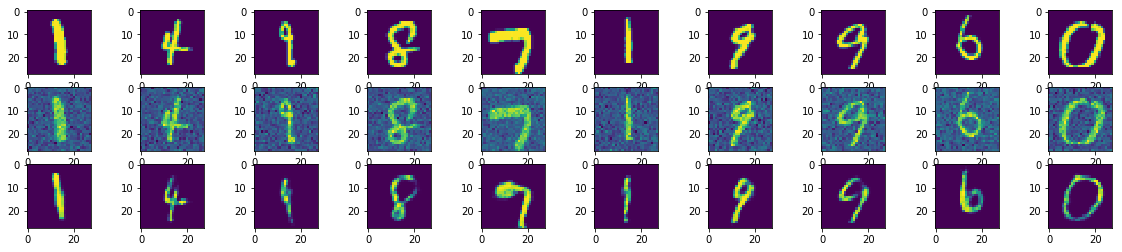

In [7]:
random_images = np.random.randint(0, len(test_x), size=num_of_test_images)
noised_images = test_x[random_images]+ np.random.normal(-0.15, 0.15, test_x[random_images].shape)
results = stacked_autoencoder.predict( noised_images)

# Comparing original images with reconstructions
f, a = plt.subplots(3, num_of_test_images, figsize=(20, 4))
for i in range(num_of_test_images):
    a[0][i].imshow(np.reshape(dataset.test.images[random_images][i], (28, 28)))
    a[1][i].imshow(np.reshape(noised_images[i], (28, 28)))
    a[2][i].imshow(np.reshape(results[i], (28, 28)))
print("Denosing Auto Encoder")
print("1 row - original images")
print("2 row - noised images")
print("3 row - recovered images")
plt.show()

In [8]:
def cluster_acc(Y_pred, Y):
    from sklearn.utils.linear_assignment_ import linear_assignment
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / Y_pred.size


In [9]:
data=[]
z =[]
u=[]
q =[[]]
p=[[]]
ff=[]

In [10]:
def dist(p,q):
    return np.linalg.norm(p-q)*np.linalg.norm(p-q)


In [11]:
def soft_assignment(i,j):
    ans =1
    summ=0
    for jj in range(len(u)):
        summ+=1/(1+dist(z[i],u[jj]))
    ans/=summ
    ans/=(1+dist(z[i],u[j]))
    return ans

In [12]:
def fi(j):
    ans =0
    for i in range(len(q)):
        ans+=q[i][j]
    return ans 

In [13]:
def classify(X,centroids):
    ans =[]
    for i in X:
        distances=[]
        for j in centroids:
            distances.append(dist(j,i))
        ans.append(np.argmin(distances))
            
   
    return np.array(ans)

def classify2(X,centroids):
    ans =[]
    for i in range(len(X)) :
        ans.append(np.argmax(p[i]))
            
   
    return np.array(ans)
def changes(x,y):
    ans =0
    for i in range(0,len(x)):
        if x[i]!=y[i]:
            ans+=1
    return ans/len(x)

In [14]:

def p_fun(i,j):
    ans = q[i][j]**2/ff[j]
    summ =0
    for jj in range(len(q[0])):
        summ+=q[i][jj]**2/ff[jj] 
    return ans/summ

def L():
    ans =0
    for i in range(len(z)):
        for j in range(len(u)):
            ans+=p[i][j]*math.log2(p[i][j]/q[i][j])
    return ans
def dLdz(i):
    summ=0
    for j in range(len(u)):
        summ+=1/(1+dist(z[i],u[j]))*(p[i][j]-q[i][j])*(z[i]-u[j])
    return summ

def dLdu(j):
    summ=0
    for i in range(len(z)):
        summ+=1/(1+dist(z[i],u[j]))*(p[i][j]-q[i][j])*(z[i]-u[j])
    return -2*summ

epochs_retrain = 100
def DEC(model,centroids,indata):
    global q
    global p
    global z
    global u
    global data
    global ff
    data=indata
    
    z=model.predict(data)
    u = centroids
    prev =classify(z,u) 
    prev_grad_z=np.zeros(z.shape)
    prev_grad_u =np.zeros(len(u))
    q =np.zeros((len(z),len(u)))
    ff = np.zeros(len(u))
    
    p =np.zeros((len(z),len(u)))
    cnt =0
    pr = model.predict(trainx)
    ans = classify(pr,u)
    print( 0,"-perc",cluster_acc(ans,trainy),"-acc")
    while True:
        
        q =np.zeros((len(z),len(u)))
        ff = np.zeros(len(u))
    
        p =np.zeros((len(z),len(u)))
     
        z=model.predict(data)
        for i in range(len(z)):
            for j in range(len(u)):
                q[i][j]= soft_assignment(i,j)
              
        for j in range(len(u)):
            ff[j]=fi(j)
        for i in range(len(z)):
            for j in range(len(u)):
                p[i][j] =p_fun(i,j)
       
       
        du = np.zeros(u.shape)
       
        
        cnt+=1 
        changed_data=z
        for j in range(len(u)):
            du[j] =LEARNING_RATE*(dLdu(j)*momentum-prev_grad_u[j]*(1-momentum))/math.sqrt(cnt)
          
            
        for i in range(len(z)):
            dz=(dLdz(i)*momentum-prev_grad_z[i]*(1-momentum))/math.sqrt(cnt)
            changed_data[i]-=dz
            prev_grad_z[i] = dz
        
       
        model.fit(data, changed_data,
                epochs=100,
                batch_size=len(z),
                verbose=False,
                shuffle = True)
        
       
          
        for j in range(len(u)):    
            u[j]=u[j]+du[j]
        prev_grad_u = du
           
        new  =classify2(model.predict(trainx),u) 
        
        perc = changes(prev,new)
        prev = new
        
        
        
        pr = model.predict(trainx)
        ans = classify2(pr,u)
        print( perc,"-ration of changed classes ",cluster_acc(ans,trainy),"-accuracy",L(),"-KLD")
        if (perc<tol):
            break
        
        
        
    return model,u 

In [15]:
layers = stacked_autoencoder.layers
enc  = layers[4](layers[3](layers[2](layers[1](input_img))))



encoder = Model(input_img, enc)
encoder.compile(optimizer=optimizers.SGD(lr=0.001), loss='mse')


print(encoder.summary())


kmeans_acc = kmeans = KMeans(n_clusters=10, random_state=0).fit(trainx)
print(cluster_acc(kmeans.predict(trainx), trainy),"K-Means accuracy")

kmeans = KMeans(n_clusters=10, random_state=0).fit(encoder.predict(trainx))
print(cluster_acc(kmeans.predict(encoder.predict(trainx)),trainy),"AE+K-Means accuaracy")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20010     
Total params: 1,665,010
Trainable params: 1,665,010
Non-trainable params: 0
_________________________________________________________________
None
0.5254 K-Means accuracy
0.7983 AE+K-Means accuaracy


In [16]:
improved_ae,centoids = DEC(encoder,kmeans.cluster_centers_,trainx)
data = improved_ae.predict(trainx)
ans = classify2(data,centoids)


print(cluster_acc(ans,trainy),"DEC accuaracy")

0 -perc 0.7983 -acc
0.0292 -ration of changed classes  0.7996 -accuracy 149.41647909305468 -KLD
0.0054 -ration of changed classes  0.7989 -accuracy 127.16622472927412 -KLD
0.0042 -ration of changed classes  0.7997 -accuracy 112.4029334715286 -KLD
0.0023 -ration of changed classes  0.8004 -accuracy 101.10658019085362 -KLD
0.0026 -ration of changed classes  0.8012 -accuracy 91.94170789432405 -KLD
0.0016 -ration of changed classes  0.8018 -accuracy 84.26083970384586 -KLD
0.0033 -ration of changed classes  0.8027 -accuracy 77.68742233330835 -KLD
0.0024 -ration of changed classes  0.8034 -accuracy 71.97755990753902 -KLD
0.0025 -ration of changed classes  0.8034 -accuracy 66.9616962545367 -KLD
0.0026 -ration of changed classes  0.8039 -accuracy 62.51597833464629 -KLD
0.0022 -ration of changed classes  0.8047 -accuracy 58.54655239931434 -KLD
0.0026 -ration of changed classes  0.8058 -accuracy 54.980369865365496 -KLD
0.0023 -ration of changed classes  0.8066 -accuracy 51.759303689481534 -KLD
0